# Instacart Feature Engineering

In [134]:
#import data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#data types
import collections
from tqdm import tqdm

#import general libraries
import gc
import time
import random
import datetime

#deep learning 
import tensorflow as tf

#sklearn 
from sklearn.preprocessing import MinMaxScaler

#keras
import keras
import IPython
from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import optimizers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', -1)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Read and merge data

In [4]:
#read data
order_products_prior_df = pd.read_csv('./data/order_products__prior.csv', engine='c',
                                        dtype={'order_id': np.int32, 'product_id': np.int32,
                                        'add_to_cart_order': np.int16, 'reordered': np.int8})
print('shape of order_products_prior_df is {}'.format(order_products_prior_df.shape))

order_products_train_df = pd.read_csv('./data/order_products__train.csv', engine='c',
                                      dtype={'order_id': np.int32, 'product_id': np.int32,
                                             'add_to_cart_order': np.int16, 'reordered': np.int8})
print('shape of order_products_train_df is {}'.format(order_products_train_df.shape))

orders_df = pd.read_csv('./data/orders.csv', engine='c',
                        dtype={'order_id': np.int32, 'user_id': np.int32, 'order_number': np.int32,
                               'order_dow': np.int8, 'order_hour_of_day': np.int8,
                               'days_since_prior_order': np.float16})
print('shape of orders_df is {}'.format(orders_df.shape))

products_df = pd.read_csv("./data/products.csv", engine='c')
print('shape of products_df is {}'.format(products_df.shape))

aisles = pd.read_csv("./data/aisles.csv")
print('shape of aisles is {}'.format(aisles.shape))

departments = pd.read_csv("./data/departments.csv")
print('shape of departments is {}'.format(departments.shape))

#merge data
df_products_orders_all = pd.concat([order_products_prior_df, order_products_train_df])

print('merging order_products with orders')

df_products_orders_all = pd.merge(df_products_orders_all, orders_df, on='order_id')
print('shape of df_products_orders_all is {}'.format(df_products_orders_all.shape))

print('grabbing aisles and departments names ')

df = df_products_orders_all.merge(products_df, how='inner', on='product_id')
df = df.merge(aisles, how='inner', on='aisle_id')
df = df.merge(departments, how='inner', on='department_id')
print('shape of df is {}'.format(df.shape))

print('sorting by user and order...')

df = df.drop(columns=['aisle_id','department_id','product_name'], axis=1)
df.sort_values(['user_id', 'order_number', 'add_to_cart_order'], axis=0, inplace=True)
df = df.reset_index(drop=True)
df.head()

shape of order_products_prior_df is (32434489, 4)
shape of order_products_train_df is (1384617, 4)
shape of orders_df is (3421083, 7)
shape of products_df is (49688, 4)
shape of aisles is (134, 2)
shape of departments is (21, 2)
merging order_products with orders
shape of df_products_orders_all is (33819106, 10)
grabbing aisles and departments names 
shape of df is (33819106, 15)
sorting by user and order...


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
0,2539329,196,1,0,1,prior,1,2,8,NaN,soft drinks,beverages
1,2539329,14084,2,0,1,prior,1,2,8,NaN,soy lactosefree,dairy eggs
2,2539329,12427,3,0,1,prior,1,2,8,NaN,popcorn jerky,snacks
3,2539329,26088,4,0,1,prior,1,2,8,NaN,popcorn jerky,snacks
4,2539329,26405,5,0,1,prior,1,2,8,NaN,paper goods,household


In [5]:
df_sample = pd.read_csv('./data/df_sample_max_7_orders.csv')
print(df_sample.shape)
df_sample.head()

(13817856, 12)


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
0,2539329,196,1,0,1,prior,1,2,8,NaN,soft drinks,beverages
1,2539329,14084,2,0,1,prior,1,2,8,NaN,soy lactosefree,dairy eggs
2,2539329,12427,3,0,1,prior,1,2,8,NaN,popcorn jerky,snacks
3,2539329,26088,4,0,1,prior,1,2,8,NaN,popcorn jerky,snacks
4,2539329,26405,5,0,1,prior,1,2,8,NaN,paper goods,household


In [8]:
debug=True

if debug:
    df = df_sample
    print(df.shape)

(13817856, 12)


## Feature engineering

In [11]:
user_order_basket_size=pd.DataFrame(df.groupby(['user_id','order_id']).size()).rename(columns={0:'basket_size'}).reset_index()
basket_size = user_order_basket_size.merge(df, how='left', on=['user_id','order_id'])['basket_size']

In [12]:
# count of products, aisles and departments per order
basket_stats = (df
                .groupby(['user_id', 'order_id'])
                .agg({'product_id':'count','department':'nunique', 'aisle':'nunique'})
                .reset_index()
                .rename(columns={'product_id':'count_products',
                                 'department':'count_departments'
                                 ,'aisle':'count_aisles'}))

df = df.merge(basket_stats, how='left', on=['user_id','order_id'])

gc.collect()

850

In [13]:
# count of orders per user
orders_per_user = df.groupby('user_id').agg({'order_id':'nunique'}).reset_index().rename(columns={'order_id':'total_orders_per_user'})
df = df.merge(orders_per_user, how='left', on=['user_id'])

del orders_per_user
gc.collect()

df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department,count_products,count_departments,count_aisles,total_orders_per_user
0,2539329,196,1,0,1,prior,1,2,8,NaN,soft drinks,beverages,5,4,4,8
1,2539329,14084,2,0,1,prior,1,2,8,NaN,soy lactosefree,dairy eggs,5,4,4,8
2,2539329,12427,3,0,1,prior,1,2,8,NaN,popcorn jerky,snacks,5,4,4,8
3,2539329,26088,4,0,1,prior,1,2,8,NaN,popcorn jerky,snacks,5,4,4,8
4,2539329,26405,5,0,1,prior,1,2,8,NaN,paper goods,household,5,4,4,8


In [14]:
# cumsum of user lifetime
df.days_since_prior_order = df.days_since_prior_order.fillna(0)
cum_days_since_prior_order = df.groupby(['user_id','order_id']).agg({'days_since_prior_order':'mean'}).reset_index()
cum_days_since_prior_order = cum_days_since_prior_order.sort_values(by=['user_id','days_since_prior_order'])
cum_days_since_prior_order['cum_days_since_prior_order'] = cum_days_since_prior_order.groupby(['user_id'])['days_since_prior_order'].cumsum()

df = df.merge(cum_days_since_prior_order[['user_id','order_id','cum_days_since_prior_order']], how='left', on=['user_id','order_id'])


# user lifetime (how long have they been ordering)
customer_lifetime = (cum_days_since_prior_order
                        .groupby('user_id')
                        .agg({'cum_days_since_prior_order': 'max'})
                        .rename(columns={'cum_days_since_prior_order':'max_cum_days_since_prior_order'})
                        .reset_index())

df = df.merge(customer_lifetime, how='left', on=['user_id'])

del cum_days_since_prior_order
del customer_lifetime
gc.collect()

df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department,count_products,count_departments,count_aisles,total_orders_per_user,cum_days_since_prior_order,max_cum_days_since_prior_order
0,2539329,196,1,0,1,prior,1,2,8,0.0,soft drinks,beverages,5,4,4,8,0.0,131.0
1,2539329,14084,2,0,1,prior,1,2,8,0.0,soy lactosefree,dairy eggs,5,4,4,8,0.0,131.0
2,2539329,12427,3,0,1,prior,1,2,8,0.0,popcorn jerky,snacks,5,4,4,8,0.0,131.0
3,2539329,26088,4,0,1,prior,1,2,8,0.0,popcorn jerky,snacks,5,4,4,8,0.0,131.0
4,2539329,26405,5,0,1,prior,1,2,8,0.0,paper goods,household,5,4,4,8,0.0,131.0


In [15]:
products_dow_stats = df.groupby(['user_id','order_dow']).agg({'order_dow':'count'}).rename(columns={'order_dow':'count_products_ordered_dow'}).reset_index()
#products_hod_stats = df.groupby(['user_id','order_hour_of_day']).agg({'order_hour_of_day':'count'}).rename(columns={'order_hour_of_day':'count_products_ordered_hod'}).reset_index()

df = df.merge(products_dow_stats, how='left', on=['user_id','order_dow'])
#df = df.merge(df, how='left', on=['user_id','order_hour_of_day'])

del products_dow_stats
gc.collect()

49

In [18]:
# user_id order hour of day stats
orders_hod_stats = df.groupby(['user_id', 'order_hour_of_day']).agg({'order_hour_of_day':['count','mean']})

# user_id order day of week stats
orders_dow_stats = df.groupby(['user_id', 'order_dow']).agg({'order_dow':['count','mean']})

# user_id basket_stats
user_id_basket_stats = (basket_stats
                            .groupby('user_id')
                            .agg({'count_products':['sum','mean','max','min'],
                                'count_departments':['mean','max','min'], 
                                'count_aisles':['mean','max','min']}))

#Number of items reordered per user
products_per_user = (df.groupby('user_id').agg({'reordered':['sum', 'mean']}))

#feature engineering from orders dataset
days_between_orders = (orders_df
                           .groupby('user_id')
                           .agg({'days_since_prior_order': ['min','max','mean']}))

# add_to_cart_order stats (mean, min, max)
product_cart_order = df.groupby(['user_id','product_id']).agg({'add_to_cart_order': ['min','max','mean']})

gc.collect()

276

In [19]:
list_groupby_features = [orders_hod_stats, orders_dow_stats, 
                         user_id_basket_stats, products_per_user, 
                         days_between_orders, product_cart_order]

for groupby_df in list_groupby_features:
    groupby_df.columns = pd.Index([e[0] + "_" + e[1].upper() for e in groupby_df.columns.tolist()])

gc.collect()

22

In [20]:
df = df.merge(orders_hod_stats, on=['user_id', 'order_hour_of_day'])
df = df.merge(orders_dow_stats, on=['user_id', 'order_dow'])
df = df.merge(user_id_basket_stats, on='user_id')
df = df.merge(products_per_user, on='user_id')
df = df.merge(days_between_orders, on='user_id')

del orders_hod_stats
del orders_dow_stats
del user_id_basket_stats
del products_per_user
del days_between_orders
gc.collect()

21

In [21]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department,count_products,count_departments,count_aisles,total_orders_per_user,cum_days_since_prior_order,max_cum_days_since_prior_order,count_products_ordered_dow,order_hour_of_day_COUNT,order_hour_of_day_MEAN,order_dow_COUNT,order_dow_MEAN,count_products_SUM,count_products_MEAN,count_products_MAX,count_products_MIN,count_departments_MEAN,count_departments_MAX,count_departments_MIN,count_aisles_MEAN,count_aisles_MAX,count_aisles_MIN,reordered_SUM,reordered_MEAN,days_since_prior_order_MIN,days_since_prior_order_MAX,days_since_prior_order_MEAN
0,2539329,196,1,0,1,prior,1,2,8,0.0,soft drinks,beverages,5,4,4,8,0.0,131.0,9,16,8,9,2,49,6.125,11,4,3.875,5,3,5.375,10,4,38,0.77551,0.0,30.0,19.0
1,2539329,14084,2,0,1,prior,1,2,8,0.0,soy lactosefree,dairy eggs,5,4,4,8,0.0,131.0,9,16,8,9,2,49,6.125,11,4,3.875,5,3,5.375,10,4,38,0.77551,0.0,30.0,19.0
2,2539329,12427,3,0,1,prior,1,2,8,0.0,popcorn jerky,snacks,5,4,4,8,0.0,131.0,9,16,8,9,2,49,6.125,11,4,3.875,5,3,5.375,10,4,38,0.77551,0.0,30.0,19.0
3,2539329,26088,4,0,1,prior,1,2,8,0.0,popcorn jerky,snacks,5,4,4,8,0.0,131.0,9,16,8,9,2,49,6.125,11,4,3.875,5,3,5.375,10,4,38,0.77551,0.0,30.0,19.0
4,2539329,26405,5,0,1,prior,1,2,8,0.0,paper goods,household,5,4,4,8,0.0,131.0,9,16,8,9,2,49,6.125,11,4,3.875,5,3,5.375,10,4,38,0.77551,0.0,30.0,19.0


In [22]:
user_product_reorders = df.groupby(['user_id','product_id']).agg({'reordered':'sum'}).rename(columns={'reordered':'sum_product_reorders_by_user'}).reset_index()
product_reorder = df.groupby('product_id').agg({'reordered':'sum'}).rename(columns={'reordered':'sum_total_product_reorders'}).reset_index()

In [23]:
df = df.merge(user_product_reorders, on=['user_id','product_id'])
df = df.merge(product_reorder, on=['product_id'])

del user_product_reorders
del product_reorder
gc.collect()

35

In [24]:
#reordered_MEAN == user_reorder_rate
df = (df
      .rename(columns = {'reordered_SUM':'sum_reordered_products_by_user',
                        'reordered_MEAN':'user_reorder_probability'})
      .assign(
        user_product_reorder_probability = lambda df: df.sum_product_reorders_by_user/df.sum_reordered_products_by_user,
        product_reorder_probability = lambda df: df.sum_total_product_reorders/df.shape[0]
    ))

gc.collect()
      
df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department,count_products,count_departments,count_aisles,total_orders_per_user,cum_days_since_prior_order,max_cum_days_since_prior_order,count_products_ordered_dow,order_hour_of_day_COUNT,order_hour_of_day_MEAN,order_dow_COUNT,order_dow_MEAN,count_products_SUM,count_products_MEAN,count_products_MAX,count_products_MIN,count_departments_MEAN,count_departments_MAX,count_departments_MIN,count_aisles_MEAN,count_aisles_MAX,count_aisles_MIN,sum_reordered_products_by_user,user_reorder_probability,days_since_prior_order_MIN,days_since_prior_order_MAX,days_since_prior_order_MEAN,sum_product_reorders_by_user,sum_total_product_reorders,user_product_reorder_probability,product_reorder_probability
0,2539329,196,1,0,1,prior,1,2,8,0.0,soft drinks,beverages,5,4,4,8,0.0,131.0,9,16,8,9,2,49,6.125,11,4,3.875,5,3,5.375,10,4,38,0.77551,0.0,30.0,19.0,7,10662,0.184211,0.000772
1,3367565,196,1,1,1,prior,6,2,7,19.0,soft drinks,beverages,4,3,4,8,33.0,131.0,9,9,7,9,2,49,6.125,11,4,3.875,5,3,5.375,10,4,38,0.77551,0.0,30.0,19.0,7,10662,0.184211,0.000772
2,1187899,196,1,1,1,train,11,4,8,14.0,soft drinks,beverages,11,5,10,8,14.0,131.0,24,16,8,24,4,49,6.125,11,4,3.875,5,3,5.375,10,4,38,0.77551,0.0,30.0,19.0,7,10662,0.184211,0.000772
3,2254736,196,1,1,1,prior,4,4,7,29.0,soft drinks,beverages,5,4,5,8,131.0,131.0,24,9,7,24,4,49,6.125,11,4,3.875,5,3,5.375,10,4,38,0.77551,0.0,30.0,19.0,7,10662,0.184211,0.000772
4,431534,196,1,1,1,prior,5,4,15,28.0,soft drinks,beverages,8,4,5,8,102.0,131.0,24,8,15,24,4,49,6.125,11,4,3.875,5,3,5.375,10,4,38,0.77551,0.0,30.0,19.0,7,10662,0.184211,0.000772


In [27]:
features_to_scale = ['add_to_cart_order','reordered','order_number','order_dow','order_hour_of_day','days_since_prior_order',
                     'count_products','count_departments','count_aisles','total_orders_per_user','cum_days_since_prior_order',
                     'max_cum_days_since_prior_order','count_products_ordered_dow','order_hour_of_day_COUNT','order_hour_of_day_MEAN',
                     'order_dow_COUNT','order_dow_MEAN','count_products_SUM','count_products_MEAN','count_products_MAX',
                     'count_products_MIN','count_departments_MEAN','count_departments_MAX','count_departments_MIN','count_aisles_MEAN',
                     'count_aisles_MAX','count_aisles_MIN','sum_reordered_products_by_user','user_reorder_probability',
                     'days_since_prior_order_MIN','days_since_prior_order_MAX','days_since_prior_order_MEAN','sum_product_reorders_by_user',
                     'sum_total_product_reorders','user_product_reorder_probability','product_reorder_probability']

In [26]:
#get dummies
df = pd.get_dummies(df, prefix=['aisle','department'], columns=['aisle','department'])
gc.collect()

In [36]:
#scale features
df[features_to_scale] = (df[features_to_scale]-df[features_to_scale].min())/((df[features_to_scale].max()-df[features_to_scale].min()))

gc.collect()
df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,count_products,count_departments,count_aisles,total_orders_per_user,cum_days_since_prior_order,max_cum_days_since_prior_order,count_products_ordered_dow,order_hour_of_day_COUNT,order_hour_of_day_MEAN,order_dow_COUNT,order_dow_MEAN,count_products_SUM,count_products_MEAN,count_products_MAX,count_products_MIN,count_departments_MEAN,count_departments_MAX,count_departments_MIN,count_aisles_MEAN,count_aisles_MAX,count_aisles_MIN,sum_reordered_products_by_user,user_reorder_probability,days_since_prior_order_MIN,days_since_prior_order_MAX,days_since_prior_order_MEAN,sum_product_reorders_by_user,sum_total_product_reorders,user_product_reorder_probability,product_reorder_probability,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,aisle_baking ingredients,aisle_baking supplies decor,aisle_beauty,aisle_beers coolers,...,aisle_prepared meals,aisle_prepared soups salads,aisle_preserved dips spreads,aisle_protein meal replacements,aisle_red wines,aisle_refrigerated,aisle_refrigerated pudding desserts,aisle_salad dressing toppings,aisle_seafood counter,aisle_shave needs,aisle_skin care,aisle_soap,aisle_soft drinks,aisle_soup broth bouillon,aisle_soy lactosefree,aisle_specialty cheeses,aisle_specialty wines champagnes,aisle_spices seasonings,aisle_spirits,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt,department_alcohol,department_babies,department_bakery,department_beverages,department_breakfast,department_bulk,department_canned goods,department_dairy eggs,department_deli,department_dry goods pasta,department_frozen,department_household,department_international,department_meat seafood,department_missing,department_other,department_pantry,department_personal care,department_pets,department_produce,department_snacks
0,2539329,196,0.0,0.0,1,prior,0.000000,0.333333,0.347826,0.000000,0.031746,0.176471,0.053571,1.0,0.000000,0.555085,0.021680,0.050847,0.347826,0.021680,0.333333,0.08932,0.080392,0.079365,0.061224,0.209091,0.235294,0.153846,0.126812,0.160714,0.103448,0.086957,0.77551,0.0,1.0,0.633789,0.875,0.071698,0.184211,0.071698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3367565,196,0.0,1.0,1,prior,0.050505,0.333333,0.304348,0.633333,0.023810,0.117647,0.053571,1.0,0.139831,0.555085,0.021680,0.027119,0.304348,0.021680,0.333333,0.08932,0.080392,0.079365,0.061224,0.209091,0.235294,0.153846,0.126812,0.160714,0.103448,0.086957,0.77551,0.0,1.0,0.633789,0.875,0.071698,0.184211,0.071698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1187899,196,0.0,1.0,1,train,0.101010,0.666667,0.347826,0.466667,0.079365,0.235294,0.160714,1.0,0.059322,0.555085,0.062331,0.050847,0.347826,0.062331,0.666667,0.08932,0.080392,0.079365,0.061224,0.209091,0.235294,0.153846,0.126812,0.160714,0.103448,0.086957,0.77551,0.0,1.0,0.633789,0.875,0.071698,0.184211,0.071698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2254736,196,0.0,1.0,1,prior,0.030303,0.666667,0.304348,0.966667,0.031746,0.176471,0.071429,1.0,0.555085,0.555085,0.062331,0.027119,0.304348,0.062331,0.666667,0.08932,0.080392,0.079365,0.061224,0.209091,0.235294,0.153846,0.126812,0.160714,0.103448,0.086957,0.77551,0.0,1.0,0.633789,0.875,0.071698,0.184211,0.071698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,431534,196,0.0,1.0,1,prior,0.040404,0.666667,0.652174,0.933333,0.055556,0.176471,0.071429,1.0,0.432203,0.5550

In [58]:
df.shape

(13817856, 195)

## Prepare for training

In [59]:
train_orders = orders_df[orders_df['eval_set']=='train']
test_orders = orders_df[orders_df['eval_set']=='test']

In [63]:
train_features = pd.merge(train_orders[['user_id','order_id','eval_set']], df.reset_index(), on='user_id')
test_features = pd.merge(test_orders[['user_id','order_id','eval_set']], df.reset_index(), on='user_id')

In [73]:
train_features.shape

(9291529, 198)

In [65]:
test_features.head()

,user_id,order_id_x,eval_set_x,index,order_id_y,product_id,add_to_cart_order,reordered,eval_set_y,order_number,order_dow,order_hour_of_day,days_since_prior_order,count_products,count_departments,count_aisles,total_orders_per_user,cum_days_since_prior_order,max_cum_days_since_prior_order,count_products_ordered_dow,order_hour_of_day_COUNT,order_hour_of_day_MEAN,order_dow_COUNT,order_dow_MEAN,count_products_SUM,count_products_MEAN,count_products_MAX,count_products_MIN,count_departments_MEAN,count_departments_MAX,count_departments_MIN,count_aisles_MEAN,count_aisles_MAX,count_aisles_MIN,sum_reordered_products_by_user,user_reorder_probability,days_since_prior_order_MIN,days_since_prior_order_MAX,days_since_prior_order_MEAN,sum_product_reorders_by_user,sum_total_product_reorders,user_product_reorder_probability,product_reorder_probability,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,aisle_baking ingredients,...,aisle_prepared meals,aisle_prepared soups salads,aisle_preserved dips spreads,aisle_protein meal replacements,aisle_red wines,aisle_refrigerated,aisle_refrigerated pudding desserts,aisle_salad dressing toppings,aisle_seafood counter,aisle_shave needs,aisle_skin care,aisle_soap,aisle_soft drinks,aisle_soup broth bouillon,aisle_soy lactosefree,aisle_specialty cheeses,aisle_specialty wines champagnes,aisle_spices seasonings,aisle_spirits,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt,department_alcohol,department_babies,department_bakery,department_beverages,department_breakfast,department_bulk,department_canned goods,department_dairy eggs,department_deli,department_dry goods pasta,department_frozen,department_household,department_international,department_meat seafood,department_missing,department_other,department_pantry,department_personal care,department_pets,department_produce,department_snacks
0,3,2774568,test,293533,3160850,16797,0.015873,1.0,prior,0.080808,0.0,0.695652,0.233333,0.031746,0.117647,0.053571,0.8,0.088983,0.279661,0.108401,0.061017,0.695652,0.108401,0.0,0.102913,0.109804,0.079365,0.081633,0.249351,0.235294,0.153846,0.15735,0.142857,0.103448,0.091533,0.714286,0.233398,0.700195,0.400146,0.250,0.254406,0.050,0.254406,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,3,2774568,test,293534,1839752,16797,0.031746,1.0,prior,0.060606,0.0,0.652174,0.233333,0.063492,0.235294,0.107143,0.8,0.029661,0.279661,0.108401,0.027119,0.652174,0.108401,0.0,0.102913,0.109804,0.079365,0.081633,0.249351,0.235294,0.153846,0.15735,0.142857,0.103448,0.091533,0.714286,0.233398,0.700195,0.400146,0.250,0.254406,0.050,0.254406,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,3,2774568,test,361920,676467,47766,0.015873,1.0,prior,0.090909,0.5,0.695652,0.566667,0.039683,0.235294,0.071429,0.8,0.279661,0.279661,0.037940,0.061017,0.695652,0.037940,0.5,0.102913,0.109804,0.079365,0.081633,0.249351,0.235294,0.153846,0.15735,0.142857,0.103448,0.091533,0.714286,0.233398,0.700195,0.400146,0.625,0.356345,0.125,0.356345,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,3,2774568,test,361921,2710558,47766,0.023810,1.0,prior,0.040404,0.0,0.739130,0.400000,0.079365,0.176471,0.107143,0.8,0.207627,0.279661,0.108401,0.061017,0.739130,0.108401,0.0,0.102913,0.109804,0.079365,0.081633,0.249351,0.235294,0.153846,0.15735,0.142857,0.103448,0.091533,0.714286,0.233398,0.700195,0.400146,0.625,0.356345,0.125,0.356345,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,3,2774568,test,361922,3225766,47766,0.039683,1.0,prior,0.070707

In [75]:
train_features.sort_values(['order_id_x','product_id'], inplace=True)
test_features.sort_values(['order_id_x','product_id'], inplace=True)

In [76]:
train_features.drop(['eval_set_x', 'index', 'eval_set_y'], axis=1, inplace=True)
test_features.drop(['eval_set_x', 'index', 'eval_set_y'], axis=1, inplace=True)

In [77]:
#get user and product sets
trainProducts = pd.merge(train_orders,order_products_train_df, on='order_id')
trainProducts = trainProducts.groupby('user_id')['product_id'].apply(set)
trainProducts.head()

user_id
1    {196, 26405, 27845, 46149, 13032, 39657, 26088, 25133, 38928, 10258, 49235}                                                                                                                                        
2    {24838, 11913, 45066, 31883, 48523, 38547, 24852, 32792, 7963, 22559, 12324, 33957, 22825, 9387, 45613, 22963, 48821, 2361, 41787, 5699, 13640, 5450, 19019, 16589, 45645, 21329, 1757, 12007, 34284, 26352, 31612}
5    {40706, 21413, 20843, 48204, 21616, 19057, 20114, 15349, 16185}                                                                                                                                                    
7    {17638, 29894, 47272, 45066, 13198, 37999, 40852, 12053, 43967}                                                                                                                                                    
8    {27104, 15937, 5539, 41540, 31717, 48230, 22247, 41259, 37803, 21903, 10960, 7058, 4853, 47766, 48121, 25659, 23165, 28

In [78]:
trainLabels = []
for row in tqdm(train_features.itertuples()):
    trainLabels += [row.product_id in trainProducts[row.user_id]]
print(len(trainLabels))
print(train_features.shape)


9291529it [05:10, 29941.36it/s]


9291529
(9291529, 195)


In [118]:
X_train = train_features.drop(['user_id', 'order_id_x','order_id_y','product_id'], axis=1).fillna(0).as_matrix()[:2000000]
Y_train = np.array(trainLabels).astype('int8')[:2000000]

/Users/waficel-assi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [138]:
# fix random seed for reproducibility
np.random.seed(7)

# create model
model = Sequential()
model.add(Dense(180, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(160, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(80, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

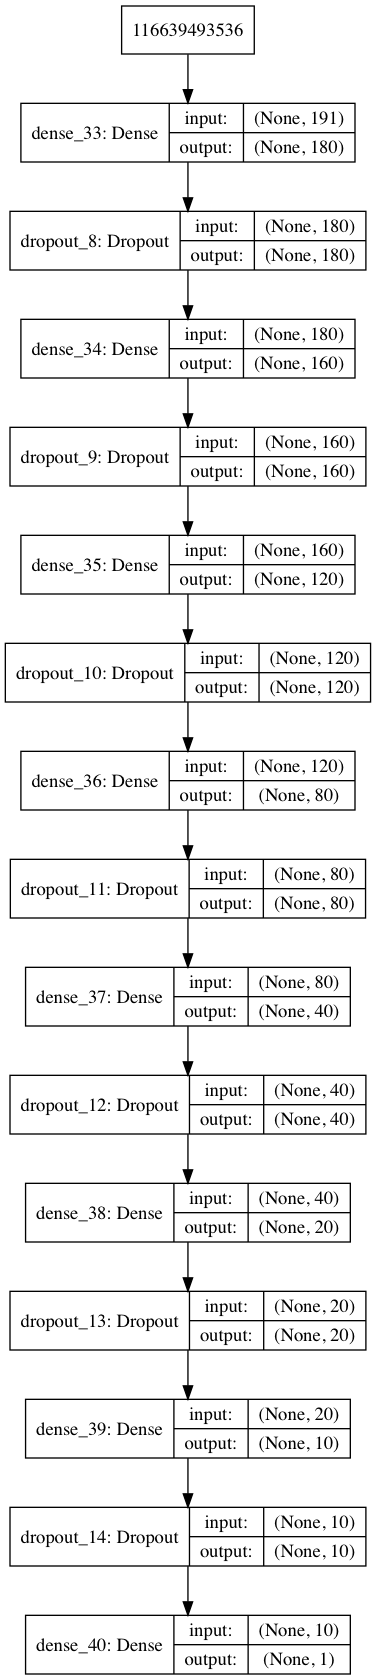

In [139]:
keras.utils.plot_model(model, to_file='test_keras_plot_model.png', show_shapes=True)
IPython.display.Image('test_keras_plot_model.png')

In [141]:
# Compile model
adam = optimizers.Adam()

# Fit the model
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=5,verbose=0, callbacks=[TQDMNotebookCallback()])


HBox(children=(IntProgress(value=0, description='Training', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=2000000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=2000000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=2000000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=2000000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=2000000), HTML(value='')))

In [170]:
test_features[test_features.user_id==36855]

,user_id,order_id_x,order_id_y,product_id,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,count_products,count_departments,count_aisles,total_orders_per_user,cum_days_since_prior_order,max_cum_days_since_prior_order,count_products_ordered_dow,order_hour_of_day_COUNT,order_hour_of_day_MEAN,order_dow_COUNT,order_dow_MEAN,count_products_SUM,count_products_MEAN,count_products_MAX,count_products_MIN,count_departments_MEAN,count_departments_MAX,count_departments_MIN,count_aisles_MEAN,count_aisles_MAX,count_aisles_MIN,sum_reordered_products_by_user,user_reorder_probability,days_since_prior_order_MIN,days_since_prior_order_MAX,days_since_prior_order_MEAN,sum_product_reorders_by_user,sum_total_product_reorders,user_product_reorder_probability,product_reorder_probability,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,aisle_baking ingredients,aisle_baking supplies decor,aisle_beauty,aisle_beers coolers,...,aisle_prepared meals,aisle_prepared soups salads,aisle_preserved dips spreads,aisle_protein meal replacements,aisle_red wines,aisle_refrigerated,aisle_refrigerated pudding desserts,aisle_salad dressing toppings,aisle_seafood counter,aisle_shave needs,aisle_skin care,aisle_soap,aisle_soft drinks,aisle_soup broth bouillon,aisle_soy lactosefree,aisle_specialty cheeses,aisle_specialty wines champagnes,aisle_spices seasonings,aisle_spirits,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt,department_alcohol,department_babies,department_bakery,department_beverages,department_breakfast,department_bulk,department_canned goods,department_dairy eggs,department_deli,department_dry goods pasta,department_frozen,department_household,department_international,department_meat seafood,department_missing,department_other,department_pantry,department_personal care,department_pets,department_produce,department_snacks
806928,36855,17,234692,1283,0.031746,0.0,0.010101,0.000000,0.391304,1.0,0.063492,0.294118,0.107143,0.2,0.177966,0.177966,0.02168,0.027119,0.391304,0.02168,0.000000,0.046602,0.090196,0.063492,0.061224,0.236364,0.294118,0.153846,0.130435,0.107143,0.103448,0.01373,0.222222,0.033325,1.0,0.358398,0.000,0.000034,0.000000,0.000034,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
806930,36855,17,3248434,6291,0.063492,0.0,0.020202,1.000000,0.608696,0.2,0.063492,0.235294,0.107143,0.2,0.050847,0.177966,0.02168,0.027119,0.608696,0.02168,1.000000,0.046602,0.090196,0.063492,0.061224,0.236364,0.294118,0.153846,0.130435,0.107143,0.103448,0.01373,0.222222,0.033325,1.0,0.358398,0.000,0.002824,0.000000,0.002824,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
806923,36855,17,898818,7035,0.015873,0.0,0.000000,0.166667,0.565217,0.0,0.031746,0.117647,0.053571,0.2,0.000000,0.177966,0.01084,0.027119,0.565217,0.01084,0.166667,0.046602,0.090196,0.063492,0.061224,0.236364,0.294118,0.153846,0.130435,0.107143,0.103448,0.01373,0.222222,0.033325,1.0,0.358398,0.000,0.003356,0.000000,0.003356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
806932,36855,17,898818,11494,0.031746,0.0,0.000000,0.166667,0.565217,0.0,0.031746,0.117647,0.053571,0.2,0.000000,0.177966,0.01084,0.027119,0.565217,0.01084,0.166667,0.046602,0.090196,0.063492,0.061224,0.236364,0.294118,0.153846,0.130435,0.107143,0.103448,0.01373,0.222222,0.033325,1.0,0.358398,0.000,0.001829,0.000000,0.001829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
806933,36855,17,1058761,13107,0.000000,1.0,0.030303,0.833333,0.56

In [143]:
X_test = test_features.drop(['user_id', 'order_id_x','order_id_y','product_id'], axis=1).fillna(0).as_matrix()
X_test

/Users/waficel-assi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[0.03174603, 0.        , 0.01010101, ..., 0.        , 0.        ,
        0.        ],
       [0.06349206, 0.        , 0.02020202, ..., 0.        , 0.        ,
        0.        ],
       [0.01587302, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07936508, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.08730159, 1.        , 0.03030303, ..., 0.        , 0.        ,
        0.        ],
       [0.07142857, 0.        , 0.03030303, ..., 0.        , 0.        ,
        0.        ]])

In [144]:
X_test.shape

(4526327, 191)

In [145]:
test_preds = model.predict(X_test)

In [216]:
pd.DataFrame(test_preds).describe()

,0
count,4.526327e+06
mean,3.364317e-01
std,2.375299e-01
min,0.000000e+00
25%,9.129279e-02
50%,4.211061e-01
75%,5.802147e-01
max,5.802147e-01


In [223]:
past_order_id = -1
reorderedProducts = []
output = []
i = 0 
maxProd = [0,0]

In [224]:
for row in tqdm(test_features.itertuples()):
    if (row.order_id_x!=past_order_id):
        if (past_order_id==-1):
            pass
        else:
            if (reorderedProducts == []):
                reorderedProducts.append(maxProd[0])
            output.append([past_order_id," ".join(str(i) for i in reorderedProducts)])
            reorderedProducts = []
            maxProd = [0,0]
        past_order_id = row.order_id_x
        
    if (test_preds[i]>.33):
            reorderedProducts.append(str(row.product_id))
    else:
        if (test_preds[i] > maxProd[1]):
            maxProd = [str(row.product_id),test_preds[i]]
    i+=1



0it [00:00, ?it/s]
5048it [00:00, 50115.14it/s]
10981it [00:00, 54204.41it/s]
18039it [00:00, 60022.78it/s]
25188it [00:00, 62876.67it/s]
33240it [00:00, 66406.44it/s]
41025it [00:00, 68180.81it/s]
47505it [00:04, 10740.01it/s]
55121it [00:04, 12185.88it/s]
62908it [00:04, 13606.67it/s]
70498it [00:04, 14923.49it/s]
77571it [00:04, 16081.77it/s]
84828it [00:04, 17229.89it/s]
92169it [00:05, 18348.21it/s]
100033it [00:05, 19525.08it/s]
108090it [00:05, 20693.99it/s]
115645it [00:05, 21723.43it/s]
123987it [00:05, 22861.95it/s]
131758it [00:05, 23844.40it/s]
139745it [00:05, 24837.93it/s]
147546it [00:05, 25764.76it/s]
155849it [00:05, 26746.92it/s]
163813it [00:05, 27639.89it/s]
171756it [00:06, 28475.52it/s]
179716it [00:06, 29310.01it/s]
187585it [00:06, 30081.84it/s]
195362it [00:06, 30833.61it/s]
203337it [00:06, 31593.72it/s]
211168it [00:06, 32290.72it/s]
212351it [00:18, 11261.27it/s]
212351it [00:18, 11260.19it/s]
219854it [00:18, 11597.84it/s]
228414it [00:19, 11986.17it/s]
23

2108340it [00:39, 52716.17it/s]
2117553it [00:40, 52814.10it/s]
2126762it [00:40, 52899.99it/s]
2136093it [00:40, 53000.38it/s]
2145244it [00:40, 53095.66it/s]
2154488it [00:40, 53192.69it/s]
2163634it [00:40, 53286.12it/s]
2172768it [00:40, 53378.16it/s]
2181867it [00:40, 53469.67it/s]
2191462it [00:40, 53572.90it/s]
2200702it [00:41, 53667.85it/s]
2210073it [00:41, 53765.65it/s]
2219351it [00:41, 53858.01it/s]
2228582it [00:41, 53949.49it/s]
2237777it [00:41, 54040.12it/s]
2247116it [00:41, 54134.89it/s]
2256578it [00:41, 54232.11it/s]
2265914it [00:41, 54325.90it/s]
2275428it [00:41, 54423.59it/s]
2284796it [00:41, 54512.19it/s]
2294060it [00:42, 54602.33it/s]
2303313it [00:42, 54691.10it/s]
2312537it [00:42, 54777.91it/s]
2321797it [00:42, 54867.21it/s]
2331151it [00:42, 54958.36it/s]
2340566it [00:42, 55050.53it/s]
2349864it [00:42, 55136.38it/s]
2359290it [00:42, 55228.13it/s]
2368583it [00:42, 55316.03it/s]
2377872it [00:42, 55400.86it/s]
2387103it [00:43, 55474.21it/s]
2396091i

4262278it [01:03, 66837.08it/s]
4271556it [01:03, 66877.79it/s]
4280761it [01:03, 66917.09it/s]
4290073it [01:04, 66957.90it/s]
4299298it [01:04, 66997.10it/s]
4308518it [01:04, 67034.67it/s]
4317694it [01:04, 67067.67it/s]
4327014it [01:04, 67108.08it/s]
4336329it [01:04, 67148.39it/s]
4345507it [01:04, 67182.00it/s]
4354755it [01:04, 67221.06it/s]
4363977it [01:04, 67259.65it/s]
4373253it [01:04, 67298.81it/s]
4382442it [01:05, 67334.83it/s]
4391582it [01:05, 67370.80it/s]
4400700it [01:05, 67403.48it/s]
4409869it [01:05, 67440.69it/s]
4419164it [01:05, 67479.61it/s]
4428299it [01:05, 67499.99it/s]
4437281it [01:05, 67533.49it/s]
4446529it [01:05, 67571.68it/s]
4455883it [01:05, 67611.11it/s]
4465108it [01:06, 67648.43it/s]
4474394it [01:06, 67686.57it/s]
4483563it [01:06, 67722.41it/s]
4492722it [01:06, 67758.31it/s]
4502012it [01:06, 67796.17it/s]
4511466it [01:06, 67836.30it/s]
4520739it [01:06, 67867.37it/s]
4526327it [01:06, 67842.79it/s]

In [225]:
output[0][1]

'13107 13107 13107 21463 21463 26429 38777 39275'

In [226]:
for result in range(0,len(output)):  
    output[result][1] = " ".join(list(set(output[result][1].split(" "))))

In [227]:
output[0][1]

'13107 26429 39275 21463 38777'

In [228]:
order_id_list = []
product_output_list = []

for order_id in range(0,len(output)):
    order_id_list.append(output[order_id][0])
    
for product_list in range(0,len(output)):
    product_output_list.append(output[product_list][1]) 

In [229]:
product_output_list[0]

'13107 26429 39275 21463 38777'

In [230]:
kernel_submission = pd.DataFrame({'order_id':order_id_list, 'products':product_output_list})
print(kernel_submission.shape)
kernel_submission.head()

(74999, 2)


,order_id,products
0,17,13107 26429 39275 21463 38777
1,34,39475 47792 44663 7035 47029 39180 16083
2,137,2326 27104 28934 41787 21903 33716 18465 29594 15975 14992 24235 38689 5134 23794 24852 34126 46587 13304 25890 43068 37065
3,182,40377 27104 26128 11198 39275 10243 13629 8021 37642 45633 31737 29079 32109 9337 5479 33000 47209 47672 41149 11520 10025
4,257,27104 30489 19519 36735 35734 27966 4605 47547 24964 1025 37646 28476 29837 13870 21137 24838 49235 11782 30233 24852 39475 45013 12456 11140 14429 32666 25659


In [ ]:
kernel_submission.to_csv('~/submission_try1_Sep2.csv', index=False)